**DICODING - HANIF IZZUDIN RAHMAN**

In [4]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
data_train = pd.read_csv('D202.csv')
data_train.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [34]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


In [6]:
data_train.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

In [8]:
dates = data_train['DATE'].values
starts  = data_train['START TIME'].values
ends  = data_train['END TIME'].values
usages  = data_train['USAGE'].values

In [9]:
dates

array(['10/22/2016', '10/22/2016', '10/22/2016', ..., '10/24/2018',
       '10/24/2018', '10/24/2018'], dtype=object)

In [10]:
starts

array(['0:00', '0:15', '0:30', ..., '23:15', '23:30', '23:45'],
      dtype=object)

In [11]:
ends

array(['0:14', '0:29', '0:44', ..., '23:29', '23:44', '23:59'],
      dtype=object)

In [12]:
usages

array([0.01, 0.01, 0.01, ..., 0.03, 0.03, 0.03])

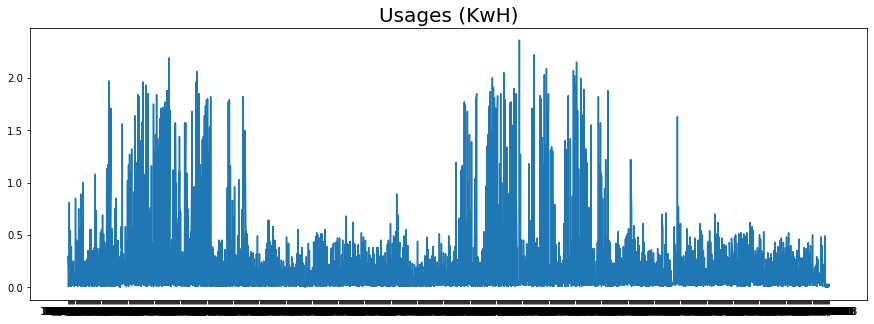

In [17]:
plt.figure(figsize=(15,5))
plt.plot(dates, usages)
plt.title('Usages (KwH)',
          fontsize=20);

In [18]:
from sklearn.model_selection import train_test_split
dates_train, dates_test, usages_train, usages_test = train_test_split(dates, usages, test_size=0.2, random_state=42, shuffle=False)

In [19]:
dates_train

array(['10/22/2016', '10/22/2016', '10/22/2016', ..., '5/31/2018',
       '5/31/2018', '5/31/2018'], dtype=object)

In [20]:
dates_test

array(['5/31/2018', '5/31/2018', '5/31/2018', ..., '10/24/2018',
       '10/24/2018', '10/24/2018'], dtype=object)

In [21]:
usages_train

array([0.01, 0.01, 0.01, ..., 0.21, 0.07, 0.07])

In [22]:
usages_test

array([0.07, 0.07, 0.06, ..., 0.03, 0.03, 0.03])

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [38]:
usages_train_windowed = windowed_dataset(usages_train, window_size=60, batch_size=50, shuffle_buffer=500)

usages_test_windowed = windowed_dataset(usages_test, window_size=60, batch_size=50, shuffle_buffer=500)

In [39]:
usages_train_windowed, usages_test_windowed

(<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>)

In [40]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [41]:
optimizer = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [42]:
# callbacks
mae_threshold = 0.1
print("mae_threshold: ", mae_threshold)
class my_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('mae') <= mae_threshold:
            print('\nFor Epoch', epoch, '\nMAE has reach = %2.2f%%' %(logs['mae']), 'training has been stopped.')
            self.model.stop_training = True

mae_threshold:  0.1


In [43]:
history = model.fit(usages_train_windowed, epochs=100, validation_data=usages_test_windowed, verbose=1, callbacks=[my_callbacks()])

Epoch 1/100
1125/1125 [==============================] - 77s 66ms/step - loss: 0.0199 - mae: 0.1041 - val_loss: 0.0032 - val_mae: 0.0515
Epoch 2/100
1125/1125 [==============================] - 75s 66ms/step - loss: 0.0158 - mae: 0.0865 - val_loss: 0.0027 - val_mae: 0.0457

For Epoch 1 
MAE has reach = 0.09% training has been stopped.


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


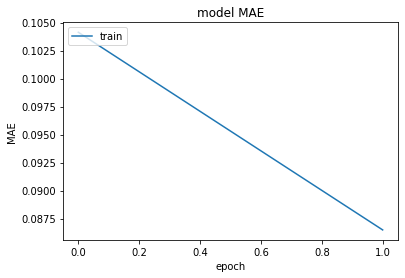

In [44]:
# Visualize
import matplotlib.pyplot as plt
import numpy
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()